<a href="https://colab.research.google.com/github/paulcodrea/dissertation/blob/main/6_LSTM_prediction_BTC_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
!pip install wandb --quiet

In [76]:
!wandb login
# cb34a0b023a44c8d62a2d3cefe662c5437f3e003

wandb: Currently logged in as: paulcodrea (use `wandb login --relogin` to force relogin)


In [77]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
from time import time
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout 
from keras.layers import LSTM
from time import time
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [78]:
wandb.init(project="6_LSTM-precition_BTC_price", entity="paulcodrea")

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▆▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁█▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
best_epoch,0
best_val_loss,0.0004
epoch,69
loss,0.0047
val_loss,0.0008


In [128]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 70, 
    "batch_size": 2,
    "train_p": 0.55, 
    "val_p": 0.05, 
    "LSTM_layer": [50, 100],
    "Dropout_layer": [0.15, 0.2],
    "activation": 'tanh',
    "timesteps": 2,
}

# Construct the metrics to store the results
metrics_df = pd.DataFrame(columns=['script','epoch', 'batch_size','timesteps',
                                   'train_p', 'val_p', 'test_p', 'loss', 'val_loss',
                                   'mse', 'rmse', 'mae', 'mape', 'runtime', 
                                   'cross_correlation'])

In [129]:
df = pd.read_csv('/content/drive/MyDrive/COMP30030_Dissertation_paul.codrea/Market-prediction/btc_only_specific_time.csv', parse_dates=True, index_col="time")
df.drop(columns=['Unnamed: 0'], inplace=True)

In [130]:
# Data normalization. This is one of the first steps to normalize the values. 
# The goal is to change the values of numeric columns in the data set to a common 
# scale, wihtout distorting differeces in the randes of values. 

df_values = df.values
sc = MinMaxScaler()
data_scaled = sc.fit_transform(df_values)

In [131]:
# Splitting data into training and testing data 
train_index = int(wandb.config['train_p'] * len(data_scaled))
val_index = train_index + int(wandb.config['val_p'] * 
                              len(data_scaled))

train = data_scaled[:train_index]
val = data_scaled[train_index:val_index]
test = data_scaled[val_index:]

In [132]:
print("train,test,val",train.shape, test.shape, val.shape)

train,test,val (100, 1) (73, 1) (9, 1)


In [133]:
xtrain , ytrain =  train[:, :1], train[:, 0]
xtest, ytest = test[:, :1], test[:, 0]
xval , yval = val[:, :1], val[:, 0]

In [134]:
# Samples -> these are the rows in the data.

# Number of hours in the future?
 # Timesteps -> these are the past observations for a feature (such as lag variable).
 # input_shape is the shape of the training dataset.
timesteps = wandb.config["timesteps"]
n_features = 1 # Columns in the data. Should be set to 1 since we only have 'close' column. 

train_len = len(xtrain) - timesteps
test_len = len(xtest) - timesteps
val_len = len(xval) - timesteps

x_train = np.zeros((train_len, timesteps, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i + timesteps
    x_train[i] = xtrain[i: ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = np.zeros((test_len, timesteps, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i + timesteps
    x_test[i] = xtest[i: ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_val = np.zeros((val_len, timesteps, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i + timesteps
    x_val[i] = xval[i: ytemp]
    y_val[i] = yval[ytemp]

print("x_val", x_val.shape)
print("y_val", y_val.shape)


################################################################################
# 2 hidden layers with 50 neurons each and a dropout between every one of them. 
# Start with Sequencial class. 
model = Sequential() 

# return_sequence will return a sequence rather than a single value for each input.
# Sequential model -> as apipeline with raw data fed in
model.add(LSTM(wandb.config['LSTM_layer'][0], input_shape = (timesteps, n_features), 
               return_sequences=True, activation=wandb.config['activation']))

# Dropout Regularisation - method of ignoring and dropping random units during training. 
# This is essential to prevent overfitting. e.g. Dropout of 15%
model.add(Dropout(wandb.config['Dropout_layer'][0]))
model.add(LSTM(wandb.config['LSTM_layer'][1], activation=wandb.config['activation']))
model.add(Dropout(wandb.config['Dropout_layer'][1]))
model.add(Dense(1)) # This layer is at the end of the architecture and it is used for outputting a prediction.
print(model.summary())

# mean-squared-error loss function and Adam optimiser. MSE is a standard loss function for a regression model.
# adam -> optimiser algorithm
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model.
# Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training 
# once the model performance stops improving on a hold out validation dataset.
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  
                          verbose=1, mode='min')

start = time()
print("start:",0)
history = model.fit(x_train, y_train, epochs = wandb.config['epochs'], 
                    batch_size=wandb.config['batch_size'], 
                    validation_data=(x_val, y_val), verbose = 1, 
                    shuffle = False, callbacks=[WandbCallback(), earlystop])

# Print the time it took to run the code
runtime = time()-start
print("Time: %.4f" % runtime)

x_train (98, 2, 1)
y_train (98,)
x_test (71, 2, 1)
y_test (71,)
x_val (7, 2, 1)
y_val (7,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 50)             10400     
                                                                 
 dropout_12 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________

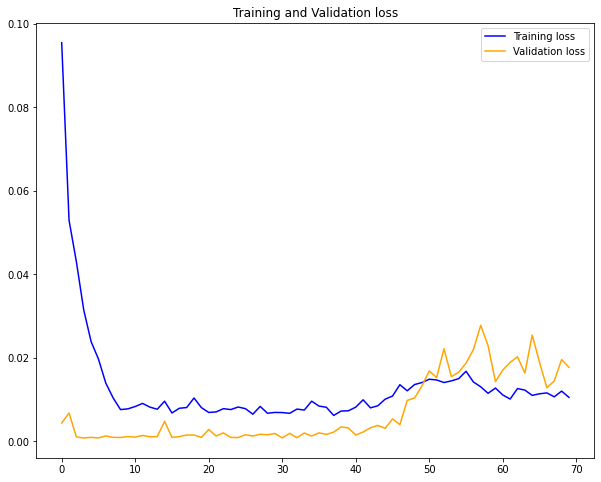

MSE: 0.0659
RMSE: 0.2567
MAE: 0.2116
MAPE (percentage): 92.1691


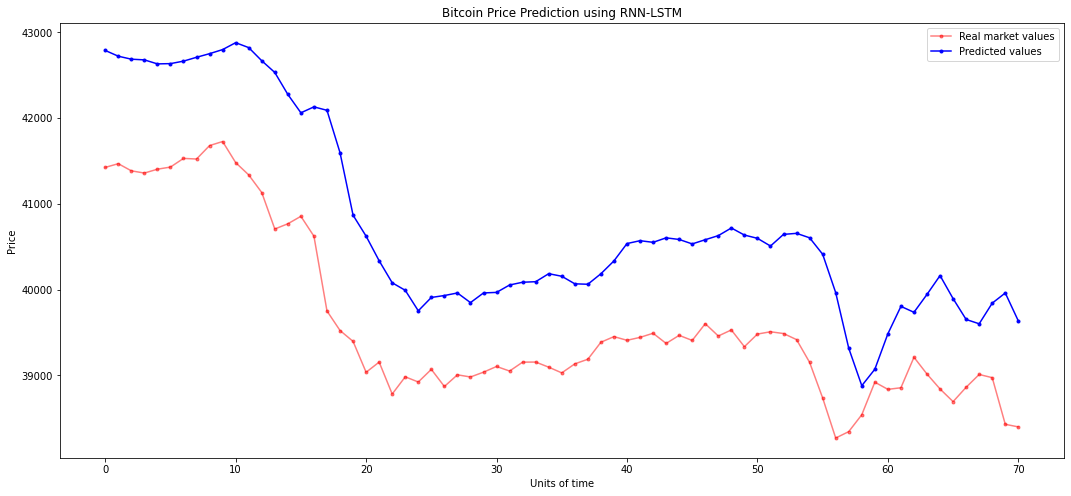

In [135]:
# Plotting data 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.show()

# Predict the model
y_pred = model.predict(x_test)

# Print out Mean Squared Error (MSE)
mse = np.mean((y_pred - y_test)**2)
print("MSE: %.4f" % mse)

# Print out Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("RMSE: %.4f" % rmse)

# Print out Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_pred - y_test))
print("MAE: %.4f" % mae)

# Print out Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print("MAPE (percentage): %.4f" % mape)

# Invers Scaling 
actual_price = sc.inverse_transform([y_test])
actual_price = np.reshape(actual_price, (actual_price.shape[1], 1))
predicted_price = sc.inverse_transform(y_pred)

# Plotting the prediction
plt.figure(figsize=(18,8))
plt.plot(actual_price, '.-', color='red', label='Real market values', alpha=0.5)
plt.plot(predicted_price, '.-', color='blue', label='Predicted values', alpha=1)
plt.title("Bitcoin Price Prediction using RNN-LSTM")
plt.xlabel("Units of time")
plt.ylabel("Price")
plt.legend()
plt.show()

## Cross-correlation analysis

In [136]:
actual_price_df = pd.DataFrame(y_test, columns=['price'])
predicted_price_df = pd.DataFrame(y_pred, columns=['price'])

In [137]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

Pearson CC for lag 0: 0.9565448738790139
Lag that maximizes the correlation 0




/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


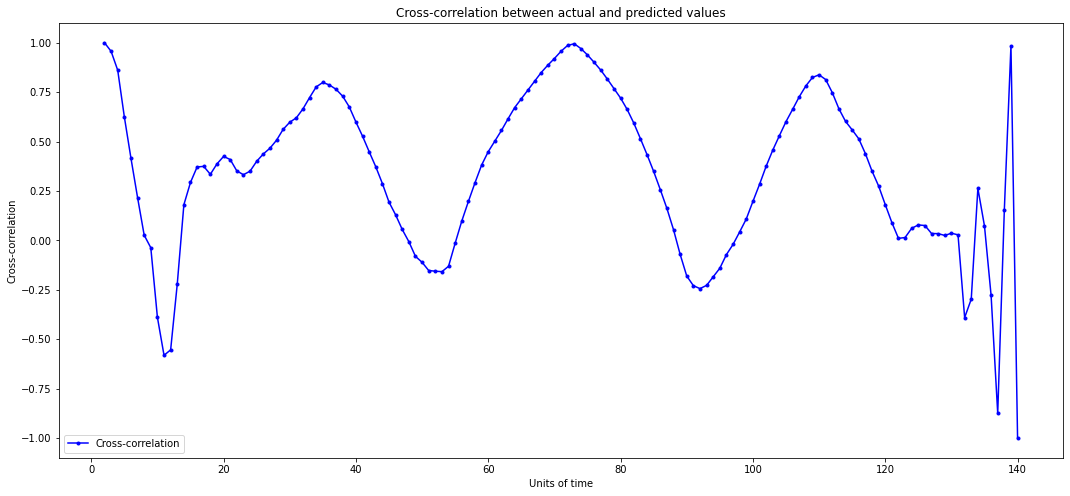



 No changes to current plotting


In [138]:
# Calculate the Pearson Cross Correlation for lag 0
curr_corr = crosscorr(predicted_price_df['price'], actual_price_df['price'], 
                      method="pearson")

# Print out the Correlation for lag 0
print(f"Pearson CC for lag 0: {curr_corr}")

# Process of improving the CC value
xcov = [crosscorr(predicted_price_df['price'], actual_price_df['price'], lag=i, method="pearson") for i in range(-len(actual_price_df), len(actual_price_df))]

# Identify the lag that maximizes the correlation
lag_max = np.argmax(xcov)
print(f"Lag that maximizes the correlation {lag_max}\n\n")

plt.figure(figsize=(18,8))
plt.plot(xcov, '.-', color='blue', label='Cross-correlation', alpha=1)
plt.title("Cross-correlation between actual and predicted values")
plt.xlabel("Units of time")
plt.ylabel("Cross-correlation")
plt.legend()
plt.show()


# If the Lag is different from 0 then shift the predicted price df and plot again
if lag_max != 0:
  # Use the lag value to shift the predicted values to align with the actual values
  predicted_price_df['price'] = predicted_price_df['price'].shift(lag_max)


  plt.figure(figsize=(18,8))
  plt.plot(predicted_price_df, '.-', color='blue', label='Predicted values', alpha=1)
  plt.plot(actual_price_df, '.-', color='red', label='Real market values', alpha=0.5)
  plt.title("Predicted values")
  plt.xlabel("Units of time")
  plt.ylabel("Price")
  plt.legend()
else:
  print("\n\n No changes to current plotting")

### Save metrics

In [139]:
# add values to metrics_df
metrics_df = metrics_df.append({'script': 'LSTM_price', 
                                'epoch': wandb.config['epochs'], 
                                'batch_size': wandb.config['batch_size'], 
                                'timesteps': wandb.config['timesteps'],
                                'train_p': wandb.config['train_p'] * 100, 
                                'val_p': wandb.config['val_p'] * 100,
                                'test_p': (1 - wandb.config['train_p'] - wandb.config['val_p']) * 100,
                                'loss': min(loss), 'val_loss': min(val_loss), 
                                'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 
                                'runtime': runtime, 'cross_correlation':curr_corr}, 
                               ignore_index=True)

## Forecast upcoming 'n_hours'

In [140]:
n_hours = 4

# Prepare dataset based on xtest
xtest_copy = xtest.copy()
xtest_copy = np.append(xtest_copy, np.zeros((n_hours, 1)), axis=0)

# Forecast the price based on the model build
y_pred_forecast = model.predict(xtest_copy)
forecast_price = sc.inverse_transform(y_pred_forecast)

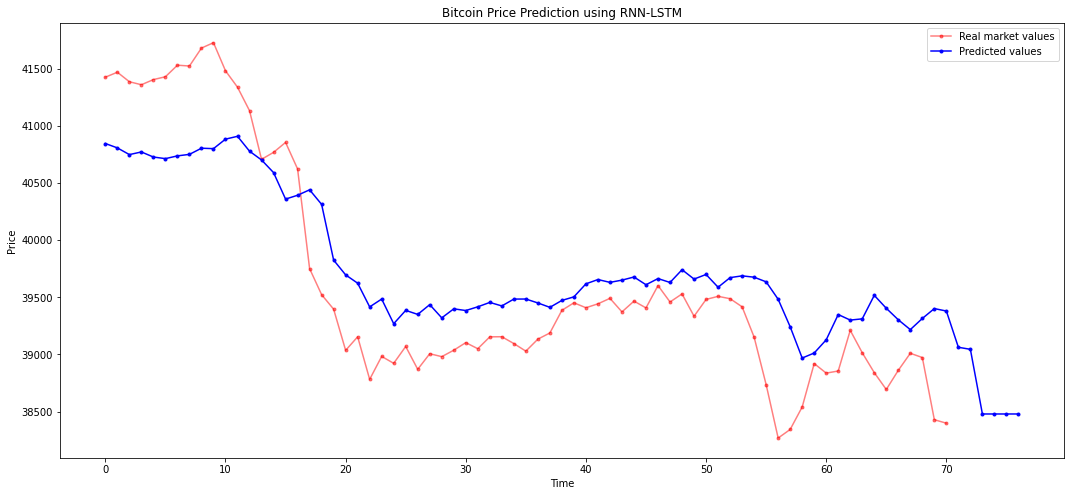

In [141]:
plt.figure(figsize=(18,8))
plt.plot(actual_price, '.-', color='red', label='Real market values', alpha=0.5)
plt.plot(forecast_price, '.-', color='blue', label='Predicted values', alpha=1)
plt.title("Bitcoin Price Prediction using RNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [142]:
# Print out statistics of the forecasted price
print(f"Forecasted price: {forecast_price[-1]}")
# Compare the price based on the n_hours before the actual price
print(f"Actual price: {actual_price[-1]}")

# Print out if the price will go down or up
if forecast_price[-1] > actual_price[-1]:
    print(f"Price will go up in the following {n_hours} hours")
else:
    print(f"Price will go down in the following {n_hours} hours")

Forecasted price: [38479.125]
Actual price: [38398.59]
Price will go up in the following 4 hours


## Collect data from the LSTM model and save it as a CSV

In [143]:
for file in os.listdir('/content/drive/MyDrive/COMP30030_Dissertation_paul.codrea/'):
    if file.endswith('metrics.csv'):
        metrics_df.to_csv(file, mode='a', header=False, index=False)
        break
    else:
        metrics_df.to_csv('/content/drive/MyDrive/COMP30030_Dissertation_paul.codrea/metrics.csv', index=False)